In [2]:
import pandas as pd
import yfinance as yf
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
def fetch_coffee_data(ticker="KC=F", start="2010-01-01", end="2025-01-01"):
    data = yf.download(ticker, start=start, end=end, interval="1mo", progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        df = data.xs('Close', level=0, axis=1)
    else:
        df = data[['Close']]
        
    df.columns = ['Coffee_Price']
    df.index = pd.to_datetime(df.index).tz_localize(None).to_period('M').to_timestamp()
    return df

def fetch_weather_data(lat, lon, start="2010-01-01", end="2024-12-30"):
    # open meteo API
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start,
        "end_date": end,
        "daily": ["temperature_2m_mean", "precipitation_sum"],
        "timezone": "auto"
    }
    
    resp = requests.get(url, params=params)
    if resp.status_code != 200:
        return pd.DataFrame()
        
    data = resp.json()
    df = pd.DataFrame({
        'date': pd.to_datetime(data['daily']['time']),
        'Temperature': data['daily']['temperature_2m_mean'],
        'Precipitation': data['daily']['precipitation_sum']
    })
    
    # from daily to monthly avg.
    df.set_index('date', inplace=True)
    df_monthly = df.resample('ME').agg({
        'Temperature': 'mean', 
        'Precipitation': 'sum'
    })
    
    df_monthly.index = df_monthly.index.to_period('M').to_timestamp()
    return df_monthly

In [4]:
# coordinates for mina gerais and sao paolo
COORDS = {
    'Minas': (-18.5122, -44.5550),
    'SP': (-23.5505, -46.6333)
}

coffee_df = fetch_coffee_data()
minas_df = fetch_weather_data(*COORDS['Minas'])
sp_df = fetch_weather_data(*COORDS['SP'])
minas_df.columns = ['Minas_Temp', 'Minas_Rain']
sp_df.columns = ['SP_Temp', 'SP_Rain']

final_df = pd.concat([coffee_df, minas_df, sp_df], axis=1, join='inner')

final_df.dropna(inplace=True)
final_df.to_csv("coffee_climate_data.csv")

print(f"Data ready. Shape: {final_df.shape}")
display(final_df.head())

Data ready. Shape: (154, 5)


,Coffee_Price,Minas_Temp,Minas_Rain,SP_Temp,SP_Rain
2010-01-01,131.699997,24.916129,43.8,23.070968,294.1
2010-02-01,129.050003,26.117857,14.7,23.932143,185.4
2010-03-01,136.149994,23.941935,200.6,22.061290,103.7
2010-04-01,135.199997,22.363333,47.9,19.410000,67.4
2010-05-01,134.250000,21.419355,43.8,17.512903,39.2


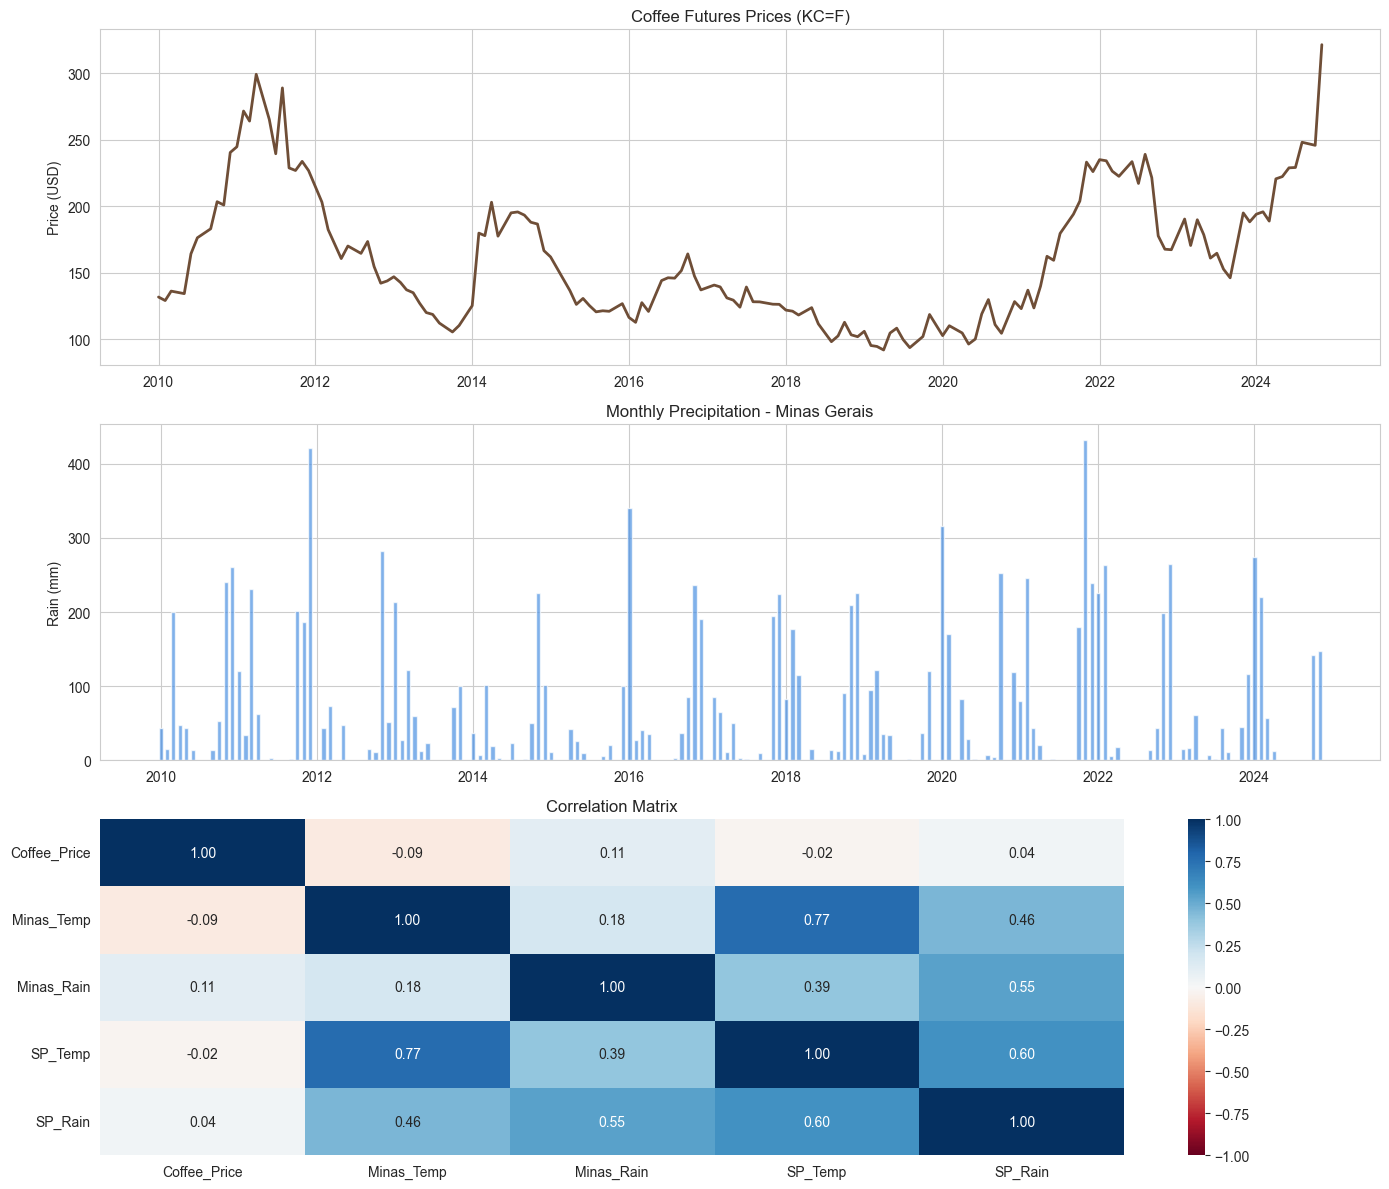

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=False)

# coffee futures prices
axes[0].plot(final_df.index, final_df['Coffee_Price'], color='#6f4e37', lw=2)
axes[0].set_title('Coffee Futures Prices (KC=F)')
axes[0].set_ylabel('Price (USD)')

# mina gerais rain
axes[1].bar(final_df.index, final_df['Minas_Rain'], color='#4a90e2', width=20, alpha=0.7)
axes[1].set_title('Monthly Precipitation - Minas Gerais')
axes[1].set_ylabel('Rain (mm)')

corr = final_df.corr()
sns.heatmap(corr, annot=True, cmap='RdBu', fmt=".2f", ax=axes[2], vmin=-1, vmax=1)
axes[2].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

In [6]:
# check for 2 month lag with pearson correlation
lag = 2
lagged_rain = final_df['Minas_Rain'].shift(lag).dropna()
aligned_price = final_df['Coffee_Price'].iloc[lag:]

r_val, p_val_corr = stats.pearsonr(lagged_rain, aligned_price)

print(f"--- Lagged Correlation (Lag={lag}) ---")
print(f"Pearson r: {r_val:.4f}")
print(f"P-value:   {p_val_corr:.4f}")

# t-test for drought and normal (%25 for drought)
threshold = final_df['Minas_Rain'].quantile(0.25)

drought_prices = final_df[final_df['Minas_Rain'] < threshold]['Coffee_Price']
normal_prices = final_df[final_df['Minas_Rain'] >= threshold]['Coffee_Price']

t_stat, p_val_ttest = stats.ttest_ind(drought_prices, normal_prices)

print(f"\n--- T-Test (Drought Impact) ---")
print(f"Avg Price (Drought): ${drought_prices.mean():.2f}")
print(f"Avg Price (Normal):  ${normal_prices.mean():.2f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value:     {p_val_ttest:.4f}")

--- Lagged Correlation (Lag=2) ---
Pearson r: 0.0621
P-value:   0.4475

--- T-Test (Drought Impact) ---
Avg Price (Drought): $171.63
Avg Price (Normal):  $157.90
T-statistic: 1.5003
P-value:     0.1356


Starting Advanced Forecast from 2016...


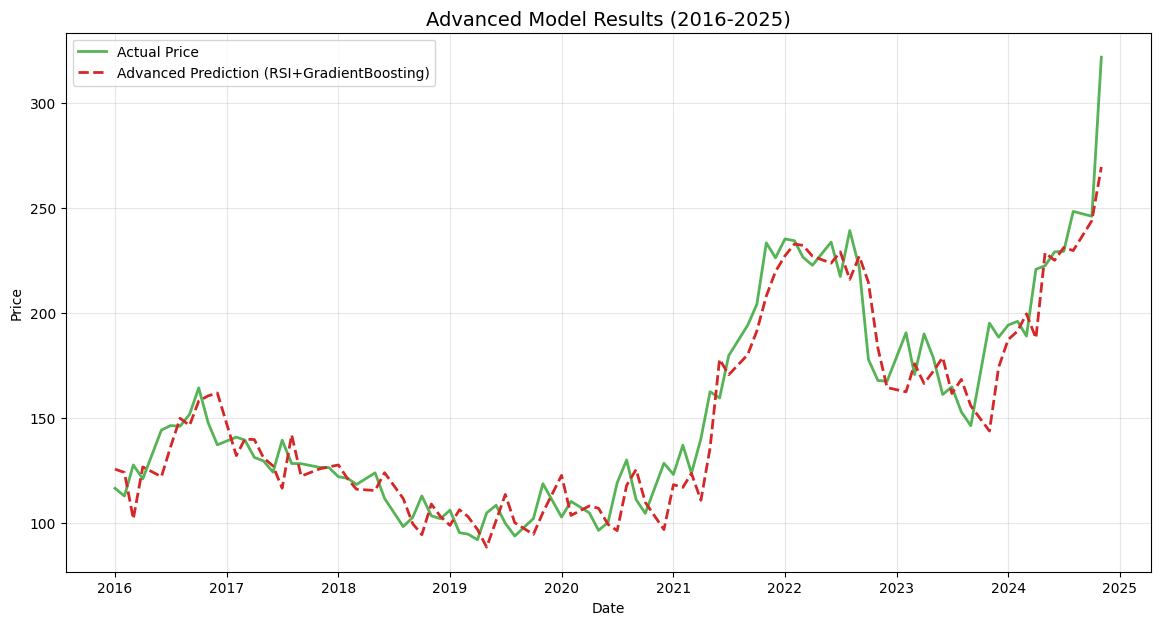

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('coffee_climate_data.csv')

if 'Unnamed: 0' in df.columns:
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
if 'Coffee_Price' in df.columns:
    df.rename(columns={'Coffee_Price': 'Close'}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df[df['Date'].dt.year >= 2010].copy()
df['Day_Index'] = (df['Date'] - df['Date'].min()).dt.days

# RSI calculation (momentum indicator)
def calculate_rsi(series, window=6):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))


# walk-forward validation
start_year = 2016
validation_indices = df[df['Date'].dt.year >= start_year].index

predictions = []
actuals = []
dates = []

feature_names = ['Res_Lag_1', 'Res_Lag_2', 'Velocity', 'RSI', 'Rolling_Mean_3']

print(f"Starting Advanced Forecast from {start_year}...")

for i in range(len(validation_indices)):
    test_idx = validation_indices[i]
    
    # train
    train_df = df.loc[:test_idx-1].copy()
    test_row = df.loc[test_idx]
    
    if len(train_df) < 50: continue

    # trend
    X_trend = train_df[['Day_Index']]
    y_trend = train_df['Close']
    trend_model = LinearRegression()
    trend_model.fit(X_trend, y_trend)
    
    train_df['Trend'] = trend_model.predict(X_trend)
    train_df['Residuals'] = train_df['Close'] - train_df['Trend']
    
    # features
    train_df['Res_Lag_1'] = train_df['Residuals'].shift(1)
    train_df['Res_Lag_2'] = train_df['Residuals'].shift(2)
    train_df['Velocity'] = train_df['Res_Lag_1'] - train_df['Res_Lag_2']
    train_df['RSI'] = calculate_rsi(train_df['Residuals'], window=6)
    train_df['Rolling_Mean_3'] = train_df['Residuals'].shift(1).rolling(window=3).mean()
    
    train_ml = train_df.dropna()
    
    X_ml = train_ml[feature_names]
    y_ml = train_ml['Residuals']
    
    # gradient boosting model
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_model.fit(X_ml, y_ml)
    
    pred_trend = trend_model.predict([[test_row['Day_Index']]])[0]
    
    last_res = train_df['Residuals']
    
    lag_1 = last_res.iloc[-1]
    lag_2 = last_res.iloc[-2]
    velocity = lag_1 - lag_2
    rsi_val = train_df['RSI'].iloc[-1]
    roll_mean = last_res.iloc[-3:].mean()
    
    feat_df = pd.DataFrame([[lag_1, lag_2, velocity, rsi_val, roll_mean]], columns=feature_names)
    pred_res = gb_model.predict(feat_df)[0]
    
    final_pred = pred_trend + pred_res
    
    predictions.append(final_pred)
    actuals.append(test_row['Close'])
    dates.append(test_row['Date'])

# visualization
plt.figure(figsize=(14, 7))
plt.plot(dates, actuals, label='Actual Price', color='#2ca02c', linewidth=2, alpha=0.8)
plt.plot(dates, predictions, label='Advanced Prediction (RSI+GradientBoosting)', color='#d62728', linestyle='--', linewidth=2)
plt.title(f"Advanced Model Results (2016-2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()